<a href="https://colab.research.google.com/github/jeffthomson15/IST_782_ADS_Portfolio_Milestone/blob/main/IST_718_Big_Data_Analytics_REIT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings


from matplotlib import pyplot
import matplotlib.pyplot as plt  # plotting series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.api import ARMA as arma
from datetime import datetime
from numpy import round
from numpy import nan
import numpy as np
from fbprophet import Prophet

from scipy.stats import uniform #for training and test splits

from scipy import stats #
import statsmodels.formula.api as smf 

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('fivethirtyeight')

import timeit
import logging

# New Section

# New Section

In [ ]:
#Reading in the data
from google.colab import files
uploaded = files.upload()

zip = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv',encoding='ISO-8859-1')
print(zip.describe)

Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence (1).csv
<bound method NDFrame.describe of        RegionID  SizeRank  RegionName  ... 1/31/2020 2/29/2020 3/31/2020
0         61639         0       10025  ...   1381453   1385737   1389268
1         84654         1       60657  ...    972038    973671    975642
2         61637         2       10023  ...   1478980   1479301   1474994
3         91982         3       77494  ...    335860    336037    336483
4         84616         4       60614  ...   1198277   1199900   1200980
...         ...       ...         ...  ...       ...       ...       ...
30459     58111     35187         802  ...    130869    131717    132127
30460     58115     35187         820  ...    100233    100404    100708
30461     58117     35187         822  ...    176689    178685    181195
30462     58121     35187         831  ...     74891     75145     75464
30463     58125     35187         851  ...    452646    454544    456250

[3046

First we will explore the dataset by running various summary functions

In [ ]:
#What's the Data Look Like
print(zip.describe)



<bound method NDFrame.describe of        RegionID  SizeRank  RegionName  ... 1/31/2020 2/29/2020 3/31/2020
0         61639         0       10025  ...   1381453   1385737   1389268
1         84654         1       60657  ...    972038    973671    975642
2         61637         2       10023  ...   1478980   1479301   1474994
3         91982         3       77494  ...    335860    336037    336483
4         84616         4       60614  ...   1198277   1199900   1200980
...         ...       ...         ...  ...       ...       ...       ...
30459     58111     35187         802  ...    130869    131717    132127
30460     58115     35187         820  ...    100233    100404    100708
30461     58117     35187         822  ...    176689    178685    181195
30462     58121     35187         831  ...     74891     75145     75464
30463     58125     35187         851  ...    452646    454544    456250

[30464 rows x 300 columns]>


In [ ]:
zip.head(10)
zip.tail(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
30454,59484,34430,4420,Zip,IA,IA,Ollie,NaN,Keokuk County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,336583.0,339243.0,343353.0,342841.0,343490.0,343518.0,345283.0,345915.0,346859.0,347691.0,347419.0,343303.0,339122.0,337255.0,337466,343318,347076,352279,353614,354057,356660,355751,355800,355671,359140,362025,363030,361604,362313,361806,363304,365438,365329,367549,369916,374221,375624,376227,377083,377915
30455,59376,34430,4109,Zip,ME,ME,Portland,Portland-South Portland,Cumberland County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,516776.0,518970.0,517291.0,515361.0,515956.0,516104.0,518147.0,521607.0,524735.0,527102.0,529277.0,530994.0,532015.0,534040.0,539868,548105,551840,556429,558852,563083,567081,571523,577436,584452,592613,596034,597471,597252,601435,604953,609370,612420,615999,620066,623246,625528,627467,632956,639095,645736
30456,60758,34430,7703,Zip,NJ,NJ,Eatontown,New York-Newark-Jersey City,Monmouth County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,569414.0,565993.0,556518.0,548634.0,544082.0,549005.0,556668.0,565946.0,565331.0,562856.0,562320.0,564822.0,567598.0,565617.0,561081,557927,559066,558443,557097,554250,555238,556013,558818,563173,570292,578711,591966,604816,617060,629123,637538,646658,655727,664169,669865,672346,672320,673446,672159,669156
30457,58084,34430,742,Zip,CO,CO,Ceiba,NaN,Gunnison County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,299551.0,297651.0,294804.0,293456.0,294690.0,294747.0,296938.0,297828.0,298417.0,298473.0,298681.0,302006.0,305989.0,313321.0,319312,323018,322970,319654,314623,310192,306539,302452,297245,291513,286252,283696,282208,283526,283739,284960,287285,289750,292526,295635,299438,301744,304403,304592,305003,304175
30458,58112,35187,803,Zip,TX,TX,Brownsville,Brownsville-Harlingen,Cameron County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137639.0,139835.0,140408.0,140619.0,139903.0,140071.0,139929.0,139858.0,139930.0,139516.0,139791.0,140443.0,139606.0,137584.0,136467,135862,135231,132093,128743,127140,126012,126842,125912,125871,126619,127225,127534,126411,126347,127396,128800,128920,128718,127307,126890,125697,124279,123206,122043,121608
30459,58111,35187,802,Zip,UT,UT,Charlotte Amalie,NaN,Kane County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105927.0,108151.0,110111.0,111816.0,112352.0,113472.0,115290.0,116205.0,116179.0,115742.0,117303.0,119158.0,121045.0,121056.0,121111,120977,121381,121595,121927,122838,124454,125526,125922,126556,126942,127895,127807,128398,129131,129779,130042,130203,130152,130602,130836,130717,130725,130869,131717,132127
30460,58115,35187,820,Zip,LA,LA,Choudrant,Ruston,Lincoln Parish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

The data contains 30464 rows and 300 columns. It represents housing data from January 1996 through March 2020. Each row is a unique ZIP of meadian house price by month, also ranked by the 'SizeRank' column. Looking at the first and last ten rows shows missing values for median prices as well as the Metro. For example, ZIP 10002 has no values for from 1996 until 2016. A quick google search shows that most homes were build around 1939 or earlier. We will try to find a way to fill in the missing data by merging another data set.

It also appears that the StateName and State columns are the same so StateName will be deleted.

In [ ]:
del zip['StateName']
zip.rename(columns={'RegionName':'Zip'}, inplace=True)

In [ ]:
zip.head(10)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216093,1212725,1208171,1206835,1207121,1208395,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980
5,91940,5,77449,Zip,TX,TX,Katy,Houston-The Woodl

In [ ]:
zip.tail(10)

,RegionID,SizeRank,Zip,RegionType,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
30454,59484,34430,4420,Zip,IA,Ollie,NaN,Keokuk County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,336583.0,339243.0,343353.0,342841.0,343490.0,343518.0,345283.0,345915.0,346859.0,347691.0,347419.0,343303.0,339122.0,337255.0,337466,343318,347076,352279,353614,354057,356660,355751,355800,355671,359140,362025,363030,361604,362313,361806,363304,365438,365329,367549,369916,374221,375624,376227,377083,377915
30455,59376,34430,4109,Zip,ME,Portland,Portland-South Portland,Cumberland County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,516776.0,518970.0,517291.0,515361.0,515956.0,516104.0,518147.0,521607.0,524735.0,527102.0,529277.0,530994.0,532015.0,534040.0,539868,548105,551840,556429,558852,563083,567081,571523,577436,584452,592613,596034,597471,597252,601435,604953,609370,612420,615999,620066,623246,625528,627467,632956,639095,645736
30456,60758,34430,7703,Zip,NJ,Eatontown,New York-Newark-Jersey City,Monmouth County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,569414.0,565993.0,556518.0,548634.0,544082.0,549005.0,556668.0,565946.0,565331.0,562856.0,562320.0,564822.0,567598.0,565617.0,561081,557927,559066,558443,557097,554250,555238,556013,558818,563173,570292,578711,591966,604816,617060,629123,637538,646658,655727,664169,669865,672346,672320,673446,672159,669156
30457,58084,34430,742,Zip,CO,Ceiba,NaN,Gunnison County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,299551.0,297651.0,294804.0,293456.0,294690.0,294747.0,296938.0,297828.0,298417.0,298473.0,298681.0,302006.0,305989.0,313321.0,319312,323018,322970,319654,314623,310192,306539,302452,297245,291513,286252,283696,282208,283526,283739,284960,287285,289750,292526,295635,299438,301744,304403,304592,305003,304175
30458,58112,35187,803,Zip,TX,Brownsville,Brownsville-Harlingen,Cameron County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137639.0,139835.0,140408.0,140619.0,139903.0,140071.0,139929.0,139858.0,139930.0,139516.0,139791.0,140443.0,139606.0,137584.0,136467,135862,135231,132093,128743,127140,126012,126842,125912,125871,126619,127225,127534,126411,126347,127396,128800,128920,128718,127307,126890,125697,124279,123206,122043,121608
30459,58111,35187,802,Zip,UT,Charlotte Amalie,NaN,Kane County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105927.0,108151.0,110111.0,111816.0,112352.0,113472.0,115290.0,116205.0,116179.0,115742.0,117303.0,119158.0,121045.0,121056.0,121111,120977,121381,121595,121927,122838,124454,125526,125922,126556,126942,127895,127807,128398,129131,129779,130042,130203,130152,130602,130836,130717,130725,130869,131717,132127
30460,58115,35187,820,Zip,LA,Choudrant,Ruston,Lincoln Parish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# What are the data types?
zip.dtypes


RegionID       int64
SizeRank       int64
Zip            int64
RegionType    object
State         object
               ...  
11/30/2019     int64
12/31/2019     int64
1/31/2020      int64
2/29/2020      int64
3/31/2020      int64
Length: 299, dtype: object

The column data types appear to be okay. We will find out soon enough.

In [ ]:
zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30464 entries, 0 to 30463
Columns: 299 entries, RegionID to 3/31/2020
dtypes: float64(265), int64(29), object(5)
memory usage: 69.5+ MB


In [ ]:
#Are all 50 states represeted? How many unique variables are in the State column?
#If I were doing this in Excel I'd pivot the data and sort so we'll try that here


print(len(zip['State'].unique()))  #https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/


51


In [ ]:
zip.sort_values('State')['State'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

Last time I checked there are 50 states so getting 51 unique values was curious. Printing the uinque "States" shows the DC is uncluded which explains the 51.

Using a crosswalk found on the Missouri.edu site showing CBSA by ZIP, we will fill in the missing Metro sections by creating a new CBSA from merging the Zillow and Missouri.edu workbooks. This will be our new "Metro" field so the old "Metro" can be deleted. 

In [ ]:
# Lets try to fill in the missing metro areas
#Reading in the data
from google.colab import files
uploaded = files.upload()

US = pd.read_csv('Geography_MSA_ZIP_2018.csv') #http://mcdc.missouri.edu/applications/geocorr2018.html
US.head()

Saving Geography_MSA_ZIP_2018.csv to Geography_MSA_ZIP_2018 (1).csv


,cbsa10,state_num,zip,state_abbreviation,cbsa_name,zip_name,population_2016,allocation_factor
0,10020,22,70510,LA,"Abbeville, LA Micropolitan Statistical Area","Abbeville, LA",26275.783,0.436
1,10020,22,70526,LA,"Abbeville, LA Micropolitan Statistical Area","Crowley, LA",92.385,0.002
2,10020,22,70528,LA,"Abbeville, LA Micropolitan Statistical Area","Delcambre, LA",1901.680,0.032
3,10020,22,70533,LA,"Abbeville, LA Micropolitan Statistical Area","Erath, LA",7564.162,0.126
4,10020,22,70542,LA,"Abbeville, LA Micropolitan Statistical Area","Gueydan, LA",3385.033,0.056


In [ ]:
US.tail(10)

In [ ]:
#Using left_join we will create a new Metro column for all ZIPs. 
#This method is chosen so metro names are consistant rather than trying 
#to replace only the missing values and then need to clean the names so they call match.

# delete all but Zip and Metro columns in the US.csv file

del US['cbsa10']
del US['state_num']
del US['state_abbreviation']
del US['zip_name']
del US['population_2016']
del US['allocation_factor']
US.rename(columns={'zip':'Zip'}, inplace=True)
US.head()

,Zip,cbsa_name
0,70510,"Abbeville, LA Micropolitan Statistical Area"
1,70526,"Abbeville, LA Micropolitan Statistical Area"
2,70528,"Abbeville, LA Micropolitan Statistical Area"
3,70533,"Abbeville, LA Micropolitan Statistical Area"
4,70542,"Abbeville, LA Micropolitan Statistical Area"


In [ ]:
US.dtypes

Zip           int64
cbsa_name    object
dtype: object

In [ ]:
zip2 = pd.merge(zip,US,on='Zip',how='left')
zip2

,RegionID,SizeRank,Zip,RegionType,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,...,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,cbsa_name
0,61639,0,10025,Zip,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268,"New York-Northern New Jersey-Long Island, NY-N..."
1,84654,1,60657,Zip,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,...,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642,"Chicago-Joliet-Naperville, IL-IN-WI Metropolit..."
2,61637,2,10023,Zip,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994,"New York-Northern New Jersey-Long Island, NY-N..."
3,91982,3,77494,Zip,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,...,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483,"Houston-Sugar Land-Baytown, TX Metropolitan St..."
4,84616,4,60614,Zip,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,...,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216

we will now create a separate dataframe for AR in order to show time series graphs for the four Metro (CBSA) Hot Springs, Little Rock, Fayetteville and Searcy.

In [ ]:
#Create our AR dataframe
df_AR = zip2[zip2['State'] == 'AR']
df_AR.head()

,RegionID,SizeRank,Zip,RegionType,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,...,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,cbsa_name
345,89249,332,71913,Zip,AR,Hot Springs,Hot Springs,Garland County,91204.0,90258.0,90182.0,90125.0,90644.0,90944.0,90806.0,90548.0,90160.0,90116.0,90160.0,90287.0,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,...,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070,149441,150307,151218,151702,152519,153299,153764,153940,154465,155178,156302,157060,157160,157093,157351,158061,158528,159213,160118,161110,161806,162347,163134,164485,166238,"Hot Springs, AR Metropolitan Statistical Area"
346,89249,332,71913,Zip,AR,Hot Springs,Hot Springs,Garland County,91204.0,90258.0,90182.0,90125.0,90644.0,90944.0,90806.0,90548.0,90160.0,90116.0,90160.0,90287.0,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,...,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070,149441,150307,151218,151702,152519,153299,153764,153940,154465,155178,156302,157060,157160,157093,157351,158061,158528,159213,160118,161110,161806,162347,163134,164485,166238,99999
698,89319,664,72034,Zip,AR,Conway,Little Rock-North Little Rock-Conway,Faulkner County,97184.0,97271.0,97483.0,97823.0,98322.0,98916.0,99686.0,100513.0,101273.0,101918.0,102468.0,103033.0,103502.0,104205.0,104874.0,105728.0,106261.0,106638.0,106857.0,107009.0,107256.0,107601.0,108106.0,108645.0,109683.0,110572.0,111355.0,111680.0,112094.0,112554.0,112843.0,113132.0,...,169308.0,169582.0,169950.0,170157.0,170426.0,170660.0,171039.0,171386.0,171589.0,171833.0,172140.0,172667.0,173115.0,173578,174113,174864,175597,176041,176604,177103,177811,178324,178867,179303,179857,180481,181027,181591,182011,182649,183101,183628,184046,184578,185073,185563,186034,186445,186853,"Little Rock-North Little Rock-Conway, AR Metro..."
916,89707,870,72701,Zip,AR,Fayetteville,Fayetteville-Springdale-Rogers,Washington County,92521.0,92670.0,92803.0,93166.0,93486.0,93901.0,94285.0,94713.0,95074.0,95441.0,95890.0,96362.0,96387.0,96430.0,96565.0,97165.0,97724.0,98126.0,98531.0,98966.0,99434.0,99900.0,100352.0,100830.0,102263.0,103586.0,104887.0,104902.0,105163.0,105428.0,105874.0,106111.0,...,192476.0,193003.0,193737.0,194088.0,193982.0,194070.0,195607.0,197708.0,199560.0,200907.0,202720.0,204034.0,205663.0,207292,208761,210155,211138,212423,213283,213988,214719,215876,217231,218568,219479,220062,220863,222232,223712,224812,225642,226377,227098,227647,227829,228159,228725,229374,229775,"Fayetteville-Springdale-Rogers, AR-MO Metropol..."
963,89749,916,72764,Zip,AR,Springdale,Fayetteville-Springdale-Rogers,Washington County,90921.0,91003.0,91077.0,91203.0,91367.0,91523.0,91801.0,91980.0,92221.0,92345.0,92608.0,92877.0,93065.0,93327.0,93611.0,94126.0,94488.0,94848.0,95266.0,95645.0,96001.0,96308.0,96706.0,97078.0,97925.0,98536.0,99152.0,99141.0,99429.0,99785.0,99758.0,100096.0,...,144677.0,145378.0,146074.0,146450.0,146537.0,146657.0,147808.0,149395.0,150897.0,151933.0,153146.0,154212.0,155569

In [ ]:
# What's are the stats and what does this subset look like?
print(df_AR.describe())
print(len(df_AR))

            RegionID      SizeRank  ...      2/29/2020      3/31/2020
count     698.000000    698.000000  ...     698.000000     698.000000
mean    89798.058739  19211.040115  ...   96998.799427   97266.008596
std     11917.727358   8657.711198  ...   46340.982442   46512.815962
min     58069.000000    332.000000  ...   11372.000000   11492.000000
25%     89303.500000  12876.500000  ...   65303.000000   64986.250000
50%     89494.000000  19529.000000  ...   90869.000000   90738.000000
75%     89666.750000  26245.500000  ...  116351.250000  116652.000000
max    399617.000000  34430.000000  ...  337720.000000  338871.000000

[8 rows x 294 columns]
698


Next we will build our time series charts. We will build one for each Metro area first and the combine them each last

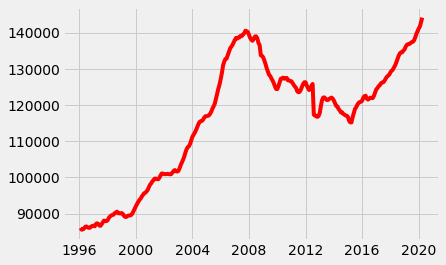

In [ ]:
hot_springs = zip2.loc[(zip2['State']=='AR') & (zip2['cbsa_name'].str.contains('Hot Springs'))]
hot_springs_mean = hot_springs.iloc[:, 7:].mean(axis=0)
hot_springs_mean.index = pd.to_datetime(hot_springs_mean.index)
plt.plot(hot_springs_mean.index, hot_springs_mean.values, color='red')
plt.show()

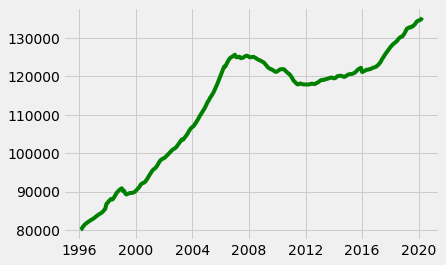

In [ ]:
little_rock = zip2.loc[(zip2['State']=='AR') & (zip2['cbsa_name'].str.contains('Little Rock'))]
little_rock_mean = little_rock.iloc[:, 7:].mean(axis=0)
little_rock_mean.index = pd.to_datetime(little_rock_mean.index)
plt.plot(little_rock_mean.index, little_rock_mean.values, color='green')
plt.show()

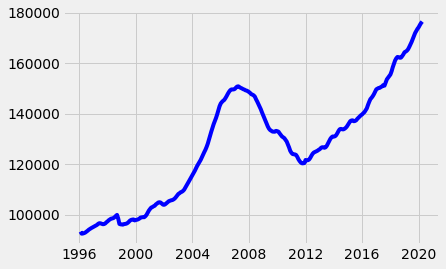

In [ ]:
fayetteville = zip2.loc[(zip2['State']=='AR') & (zip2['cbsa_name'].str.contains('Fayetteville'))]
fayetteville_mean = fayetteville.iloc[:, 7:].mean(axis=0)
fayetteville_mean.index = pd.to_datetime(fayetteville_mean.index)
plt.plot(fayetteville_mean.index, fayetteville_mean.values, color='blue')
plt.show()

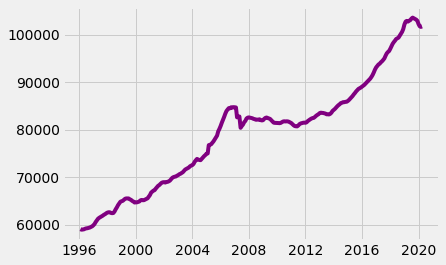

In [ ]:
searcy = zip2.loc[(zip2['State']=='AR') & (zip2['cbsa_name'].str.contains('Searcy'))]
searcy_mean = searcy.iloc[:, 7:].mean(axis=0)
searcy_mean.index = pd.to_datetime(searcy_mean.index)
plt.plot(searcy_mean.index, searcy_mean.values, color='purple')
plt.show()

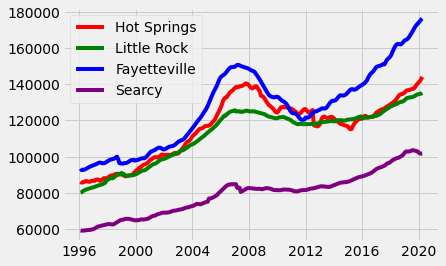

In [ ]:
plt.plot(hot_springs_mean.index, hot_springs_mean.values, color='red', label='Hot Springs')
plt.plot(little_rock_mean.index, little_rock_mean.values, color='green', label='Little Rock')
plt.plot(fayetteville_mean.index, fayetteville_mean.values, color='blue', label='Fayetteville')
plt.plot(searcy_mean.index, searcy_mean.values, color='purple', label='Searcy')
plt.legend()
plt.show()

Deciding where to live depends on the potential buyers wishes. If you're looking for price appreciation, Hot Springs, Searcy and Little Rock have appreciated around 65% since 1996 while Fayetteville is closer to 95% price appreciation. If you're looking for a consistency, Searcy has stedily appreciated and didn't experience the large price drops the other three did durng the 2008 financial crisis. 

Predictive Analytics
The author conceeds that the below method to choose which three ZIPs to invest in wasn't done using the suggested methods. The author is very new to coding still and after many attempts to work the ARIMA and Prophet models, they never came out right. Rather than giving up, a diffferent approach was used. 

The Compound Annual Growth Rate is a metric used to show the rate of return of an investment over a period of time. More specifically, it tells us the rate at which an investment would have growth if it had grown at the same rate each year. While in reality this isn't likely, it does smooth out any returns and is better than a striaght percent increase. This metric was added to the dataset in order to show which ZIPs had the highest CAGR for the previous ten years.

In [ ]:
zip3 = zip
print(zip3.columns.tolist())
zip3

['RegionID', 'SizeRank', 'Zip', 'RegionType', 'State', 'City', 'Metro', 'CountyName', '1/31/1996', '2/29/1996', '3/31/1996', '4/30/1996', '5/31/1996', '6/30/1996', '7/31/1996', '8/31/1996', '9/30/1996', '10/31/1996', '11/30/1996', '12/31/1996', '1/31/1997', '2/28/1997', '3/31/1997', '4/30/1997', '5/31/1997', '6/30/1997', '7/31/1997', '8/31/1997', '9/30/1997', '10/31/1997', '11/30/1997', '12/31/1997', '1/31/1998', '2/28/1998', '3/31/1998', '4/30/1998', '5/31/1998', '6/30/1998', '7/31/1998', '8/31/1998', '9/30/1998', '10/31/1998', '11/30/1998', '12/31/1998', '1/31/1999', '2/28/1999', '3/31/1999', '4/30/1999', '5/31/1999', '6/30/1999', '7/31/1999', '8/31/1999', '9/30/1999', '10/31/1999', '11/30/1999', '12/31/1999', '1/31/2000', '2/29/2000', '3/31/2000', '4/30/2000', '5/31/2000', '6/30/2000', '7/31/2000', '8/31/2000', '9/30/2000', '10/31/2000', '11/30/2000', '12/31/2000', '1/31/2001', '2/28/2001', '3/31/2001', '4/30/2001', '5/31/2001', '6/30/2001', '7/31/2001', '8/31/2001', '9/30/2001', '1

,RegionID,SizeRank,Zip,RegionType,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,61639,0,10025,Zip,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,84654,1,60657,Zip,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,61637,2,10023,Zip,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,91982,3,77494,Zip,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,84616,4,60614,Zip,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216093,1212725,1208171,1206835,1207121,1208395,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980
...,...,...,...,...,...,...,...,...

In [ ]:
# remove unwanted cols
del zip3['RegionID']
del zip3['City']
del zip3['State']
del zip3['Metro']
del zip3['CountyName']
del zip3['SizeRank']
del zip3['RegionType']
zip3.head()



,Zip,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,10025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,60657,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,10023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,77494,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,60614,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,681464.0,686767.0,690649.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216093,1212725,1208171,1206835,1207121,1208395,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980


In [ ]:
# Remove all columns between column index 1 to 3 
zip3.drop(zip.iloc[:, 2:282], inplace = True, axis = 1) 
  
zip3

,Zip,1/31/1996,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,10025,NaN,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,60657,364892.0,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,10023,NaN,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,77494,200475.0,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,60614,546663.0,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980
...,...,...,...,...,...,...,...,...,...,...,...,...
30459,802,NaN,130042,130203,130152,130602,130836,130717,130725,130869,131717,132127
30460,820,NaN,99865,100729,100883,101516,101698,101363,100458,100233,100404,100708
30461,822,NaN,171505,172371,172732,173377,174192,175176,175615,176689,178685,181195
30462,831,NaN,72676,73007,73330,73647,73961,74273,74583,74891,75145,75464


In [ ]:
#Adding the CAGR (compound annual growth rate) metric to show the median price increase over the life of the ZIP code. This method adjusts
#for seasonality to show a smooth price appreciation or depreciation percent change over the timeframe.
zip3['CAGR'] = zip3.iloc[:, -1].div(zip3.iloc[:, 0]).pow(1./(len(zip3.columns) - 1)).sub(1)
zip3.head()

,Zip,1/31/1996,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,CAGR
0,10025,NaN,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268,0.565670
1,60657,364892.0,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642,0.287282
2,10023,NaN,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994,0.574244
3,77494,200475.0,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483,0.142805
4,60614,546663.0,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980,0.311915


In [ ]:
zip3.sort_values(by=['CAGR'], inplace=True,ascending=False)
zip3.head(10)

,Zip,1/31/1996,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,CAGR
13039,2108,1084860.0,4888262,4910771,4916989,4919314,4923718,4932125,4939417,4956460,4973933,4982850,1.026243
3644,2116,537771.0,2363955,2366857,2369980,2375384,2383116,2386542,2392512,2401388,2415020,2424451,0.897142
2819,2118,473285.0,2270845,2270597,2271169,2275899,2288934,2299390,2312299,2324545,2340898,2355084,0.891979
23863,2112,NaN,2088636,2088614,2097614,2099861,2118843,2119831,2153887,2185383,2229533,2264232,0.885711
6022,2114,536990.0,2116813,2119348,2123218,2130314,2137185,2139015,2142470,2153257,2171615,2189384,0.879796
2051,2138,518969.0,1977776,1985563,1995110,2006430,2013092,2017735,2018879,2026743,2036147,2054464,0.867040
5886,2445,604585.0,2127534,2134852,2144365,2146465,2152025,2159077,2180148,2198015,2214014,2217861,0.857282
2433,2446,471286.0,2010486,2019344,2031859,2038933,2047015,2054995,2076732,2094271,2110732,2114637,0.849183
1469,10065,NaN,8665174,8704005,8653878,8558984,8451378,8356810,8303433,8293072,8271645,8221444,0.839668
326,10021,NaN,7240921,7269144,7242754,7182818,7129752,7080063,7076118,7082178,7077934,7048943,0.814837


Based on the CAGR, I would choose to invest in ZIPs 13039, 03644 and 02819.

**The Below Work are scatterings of the ARIMA Method   *******************************

In [ ]:
# convert zip code to col names
zip4 = zip.set_index('Zip')
# transpose time series matrices
zip4 = zip4.T
# convert indices to date time
zip4.index = pd.to_datetime(zip3.index)
zip4.head()

In [ ]:
zip_train = zip2.loc[:, '1/31/1997':'12/31/2017']
zip_train.columns = pd.to_datetime(zip_train.columns)

zip_test_2018 = zip2.loc[:, '1/31/2018':'12/31/2018']
zip_test_2018.columns = pd.to_datetime(zip_test_2018.columns)

zip_prediction_2018 = pd.DataFrame(index=zip_test_2018.index, columns=zip_test_2018.columns)
zip_prediction_2018.fillna(nan, inplace=True)

In [ ]:
zip_mean = zip_train.mean(axis=0)